## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2, os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate_camera(images):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.



    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

            #calculate camera calibration matrix
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
            dist_corr_img = cv2.undistort(img, mtx, dist, None, mtx)

    return ret, mtx, dist, rvecs, tvecs

In [111]:
def plot_images(orig_image, edited_image, fig_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(orig_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(edited_image, cmap='gray')
    ax2.set_title('Edited image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if fig_name:
        outname = os.path.join('./output_images/', str(fig_name) + '.jpg')
        plt.imsave(outname, edited_image, cmap = 'gray') 

In [112]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

def apply_sobel_operator(img, orient, sobel_kernel = 3, threshold = (0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1

    return binary_output



camera_cal/calibration3.jpg
camera_cal/calibration9.jpg
camera_cal/calibration12.jpg
camera_cal/calibration20.jpg
camera_cal/calibration16.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration7.jpg
camera_cal/calibration2.jpg
camera_cal/calibration11.jpg
camera_cal/calibration17.jpg
camera_cal/calibration19.jpg
camera_cal/calibration10.jpg
camera_cal/calibration15.jpg
camera_cal/calibration8.jpg
camera_cal/calibration6.jpg
camera_cal/calibration18.jpg


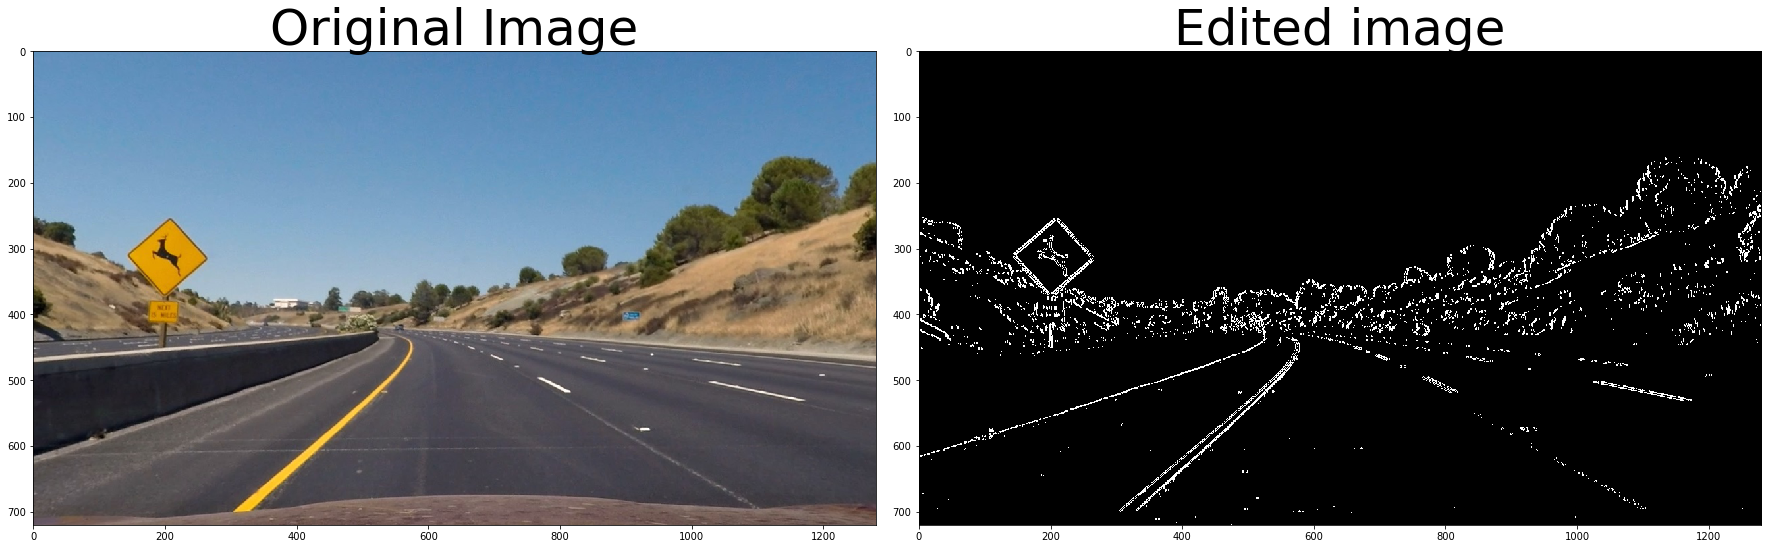

In [113]:
gradient_x = apply_sobel_operator(img, 'x', 5, (30, 100))
plot_images(img, gradient_x, 'gradient_x')

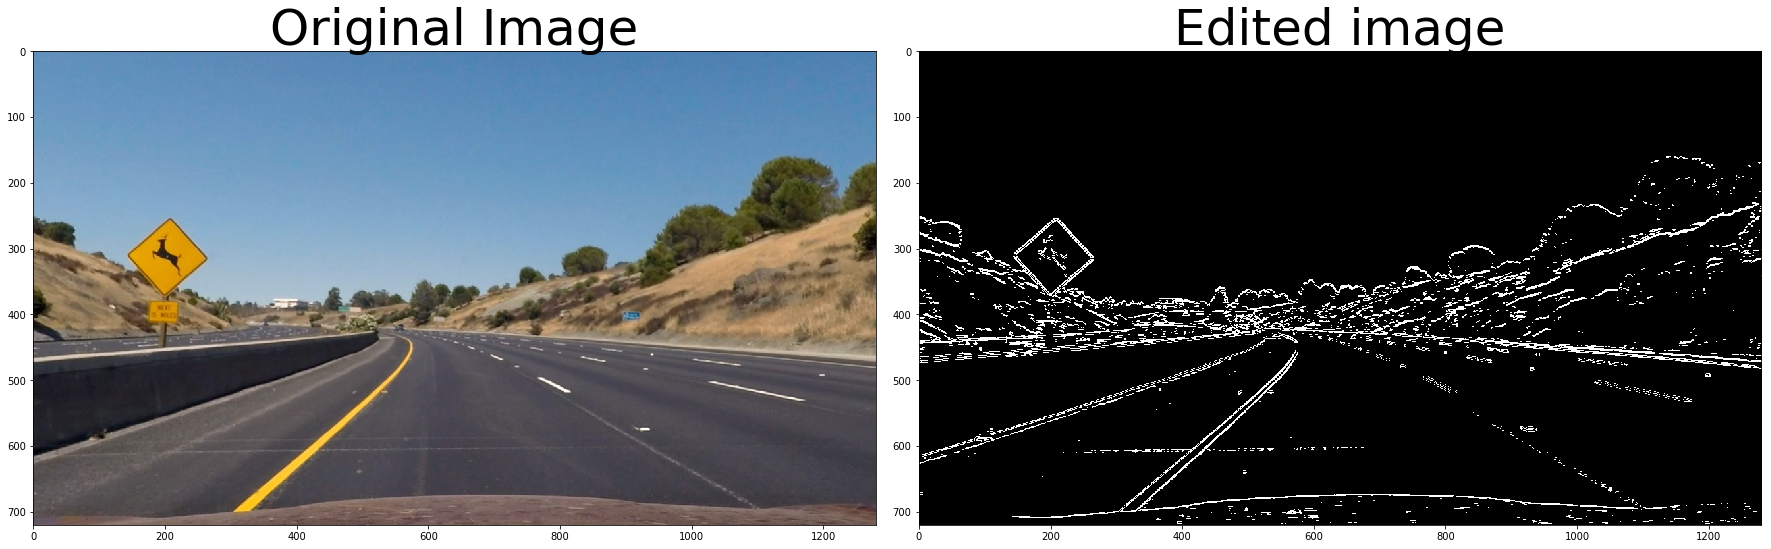

In [114]:
gradient_y = apply_sobel_operator(img, 'y', 5, (30, 100))
plot_images(img, gradient_y, 'gradient_y')

In [115]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    sobel_image = np.zeros_like(gradmag)
    thresh_min, thresh_max = mag_thresh
    sobel_image[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return sobel_image


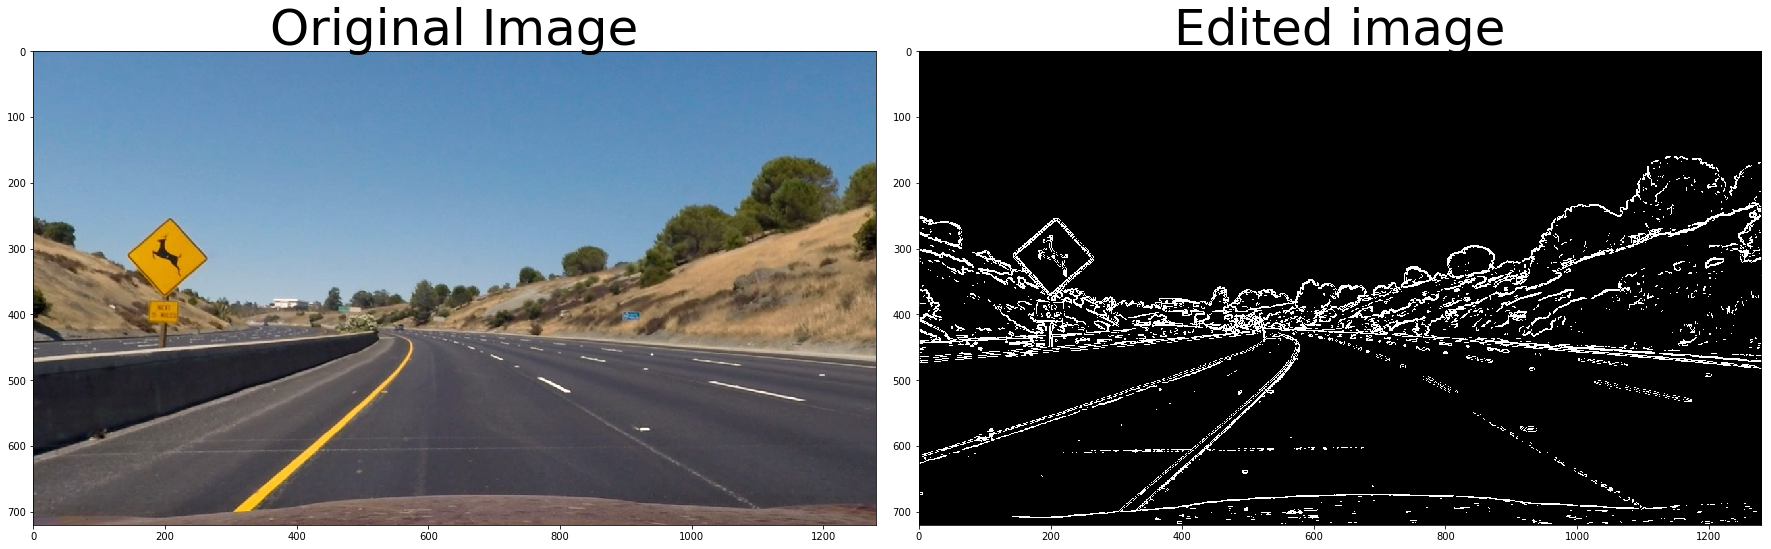

In [116]:
mag_img = mag_thresh(img, 15, (30, 100))
plot_images(img, mag_img, 'magnitude')

In [117]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    gradmag = np.arctan2(abs_sobely, abs_sobelx)
    sobel_image = np.zeros_like(gradmag)
    sobel_image[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return sobel_image

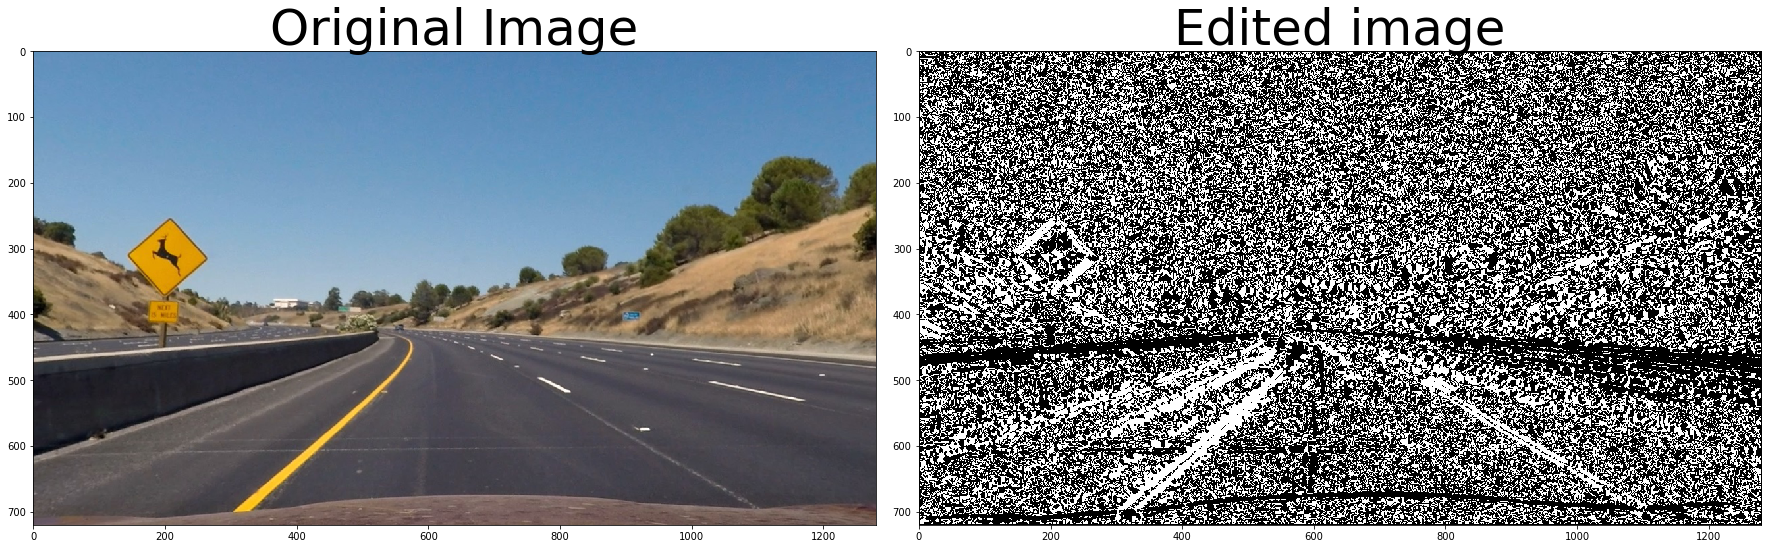

In [118]:
dir_img = dir_threshold(img, 15, (0.7, 1.3))
plot_images(img, dir_img, 'direction')

In [119]:
def color_threshold(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

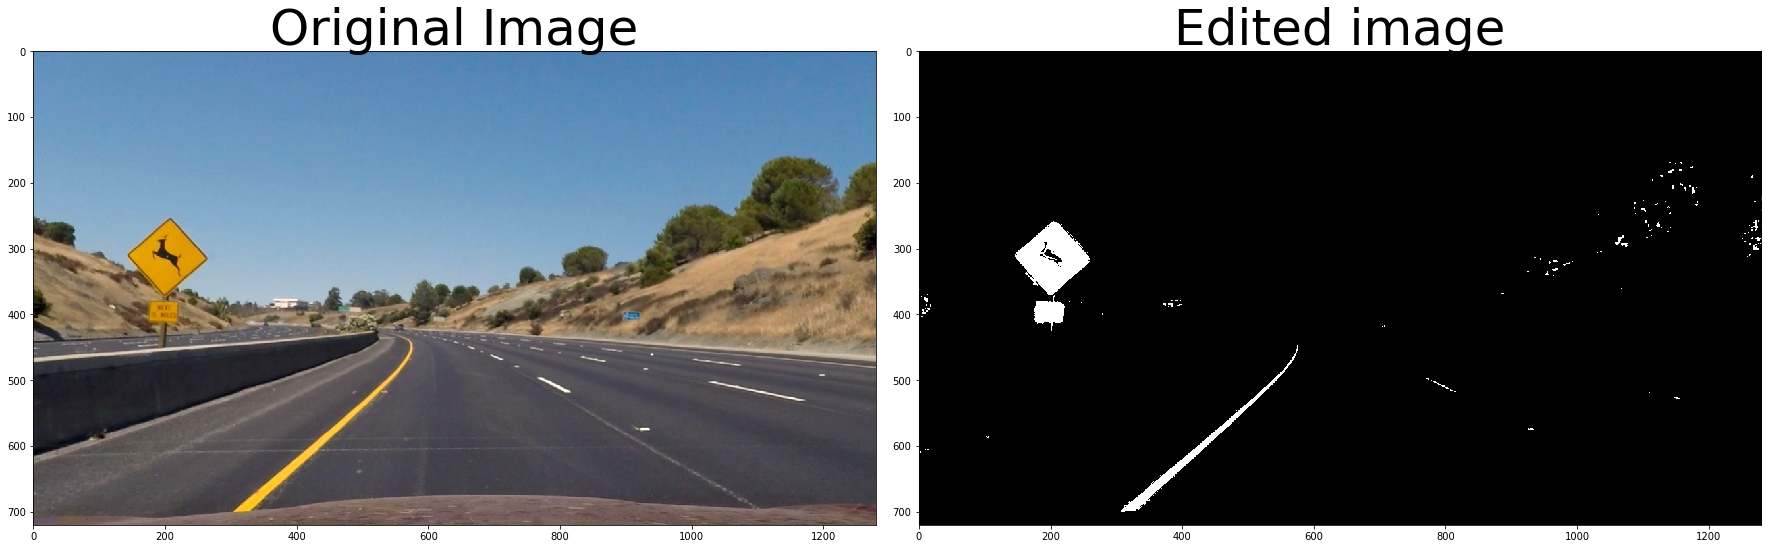

In [139]:
col_img = color_threshold(img, (170, 255))
plot_images(img, col_img, 'color')

In [121]:
def combined_threshold(gradient_x, gradient_y, mag_threshold, dir_threshold, col_threshold):
    combined = np.zeros_like(dir_threshold)
    combined[((gradient_x == 1) & (gradient_y == 1)) | ((mag_threshold == 1) & (dir_threshold == 1)) | (col_threshold == 1)] = 1

    return combined


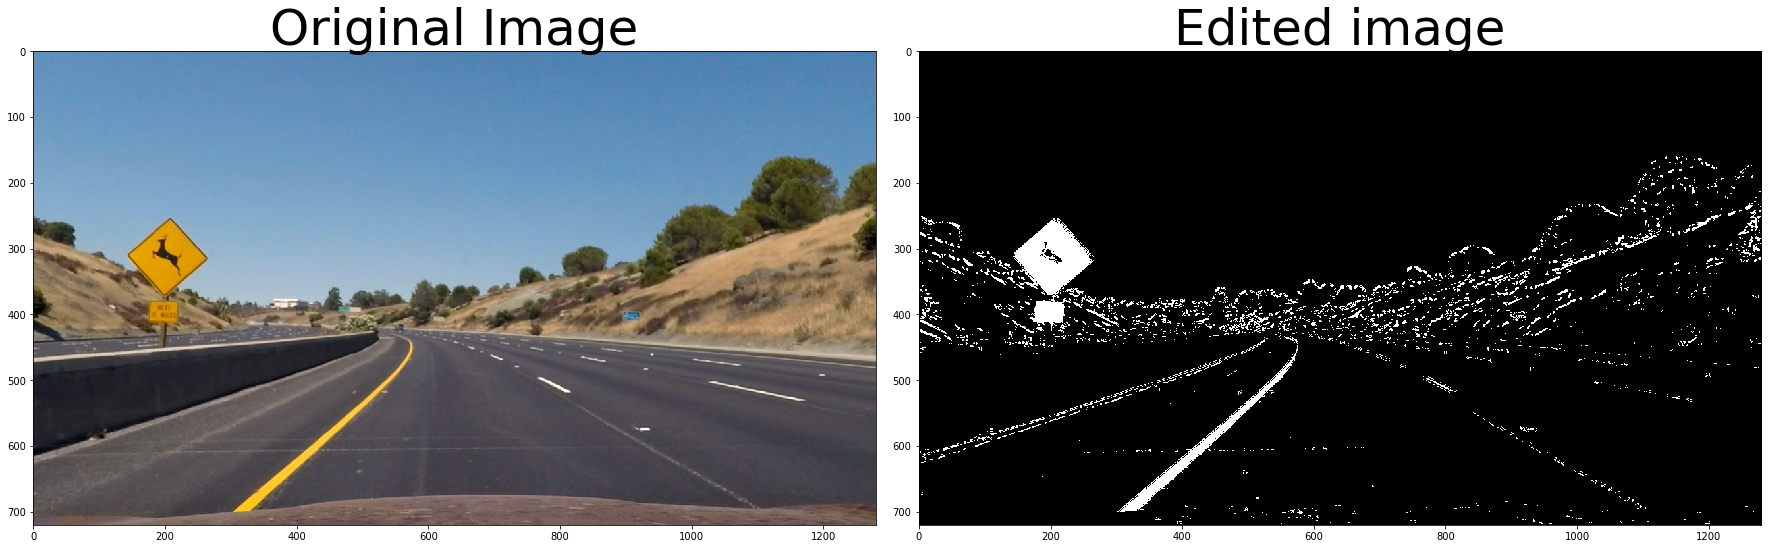

In [122]:
combined_img = combined_threshold(gradient_x, gradient_y, mag_img, dir_img, col_img)
plot_images(img, combined_img, 'combined')

In [123]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]])
    dst = np.float32([[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, src, dst, Minv

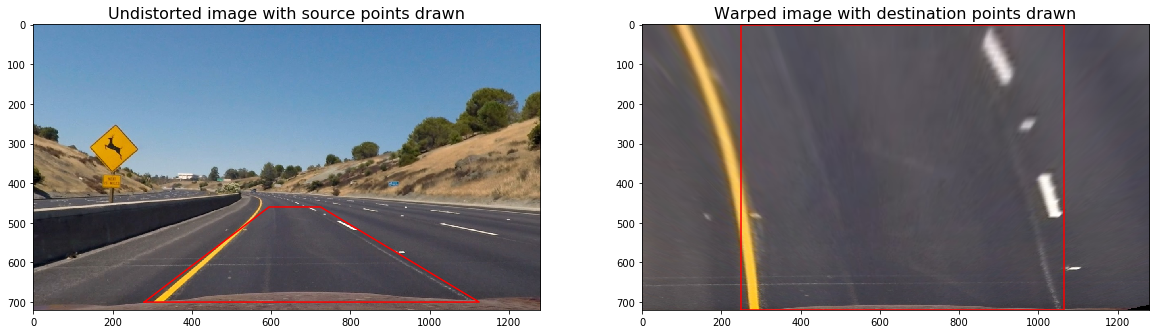

In [124]:
from matplotlib.patches import Polygon

warped_image, src, dst, M = perspective_transform(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warped_image)
outname = os.path.join('./output_images/' ,  'transform.jpg')
plt.imsave(outname, img)

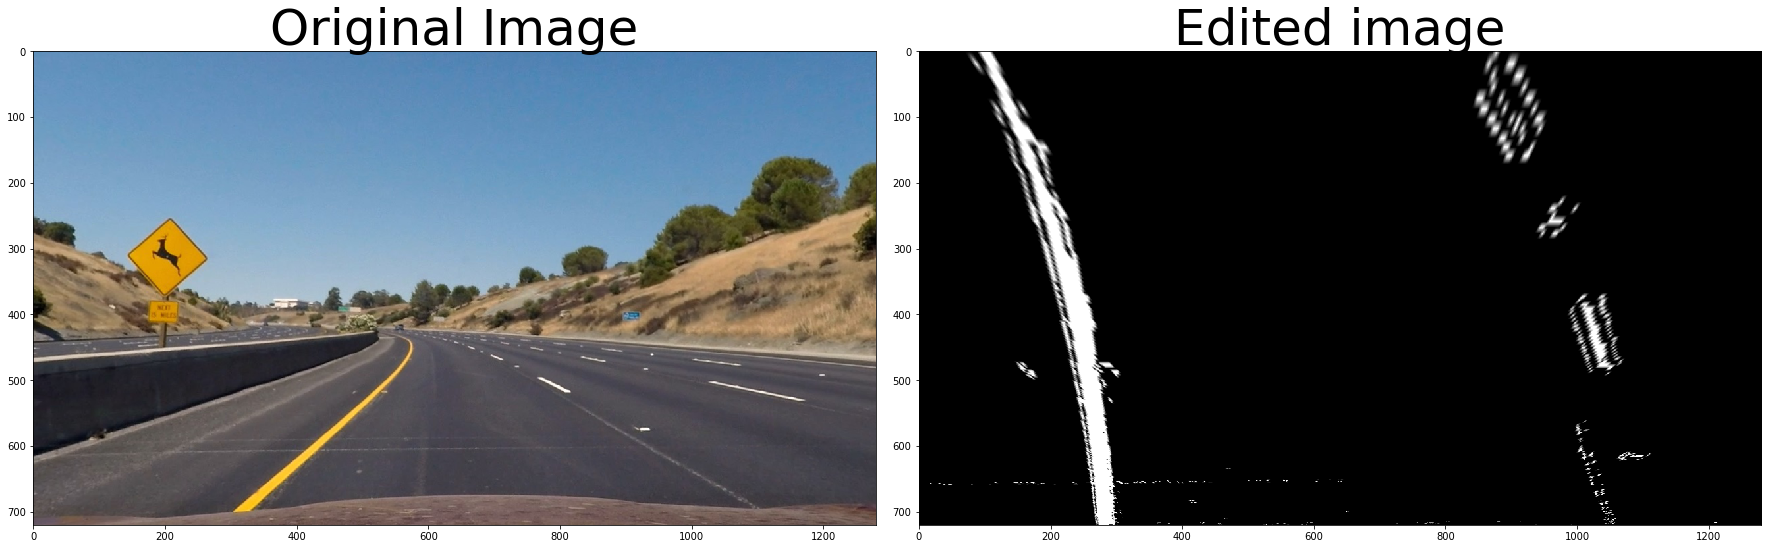

In [125]:
combined_warped_image, src, dst, M = perspective_transform(combined_img)
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis = 0)
    return histogram

histogram = hist(combined_warped_image)

plot_images(img, combined_warped_image, 'combined_warped')

In [126]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ###  Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,40,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,40,0), 3) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [40, 0, 0]
    out_img[righty, rightx] = [0, 0, 40]
    # Plots the left and right polynomials on the lane lines
    for index in range(warped_image.shape[0]):

        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (30,30,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (30,30,0))
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

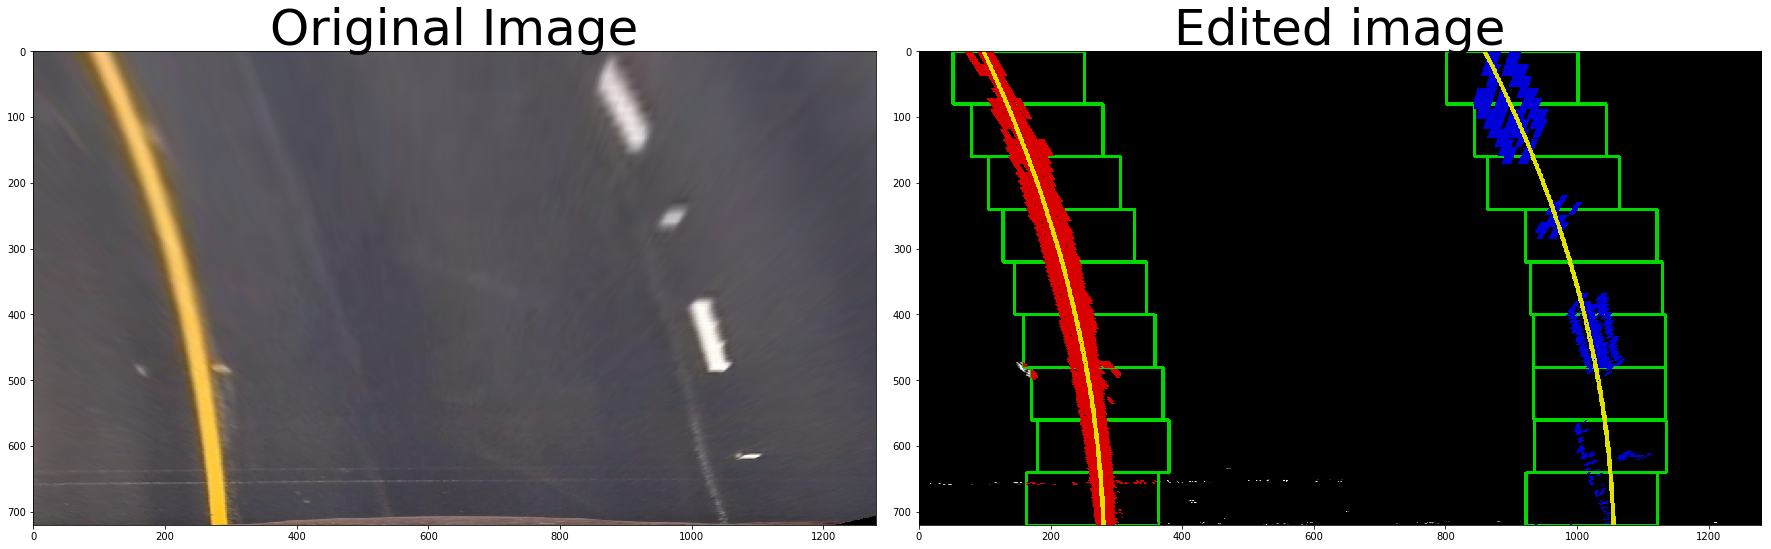

In [127]:
lines_fit, left_line, right_line, out_img = fit_polynomial(combined_warped_image)
plot_images(warped_image, out_img, None)


In [128]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, lines_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    left_fit = lines_fit[0]
    right_fit = lines_fit[1]
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
       
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [40, 0, 0]
    out_img[righty, rightx] = [0, 0, 40]
    
    for index in range(warped_image.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (30,30,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (30,30,0))
    ## End visualization steps ##
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty),out_img


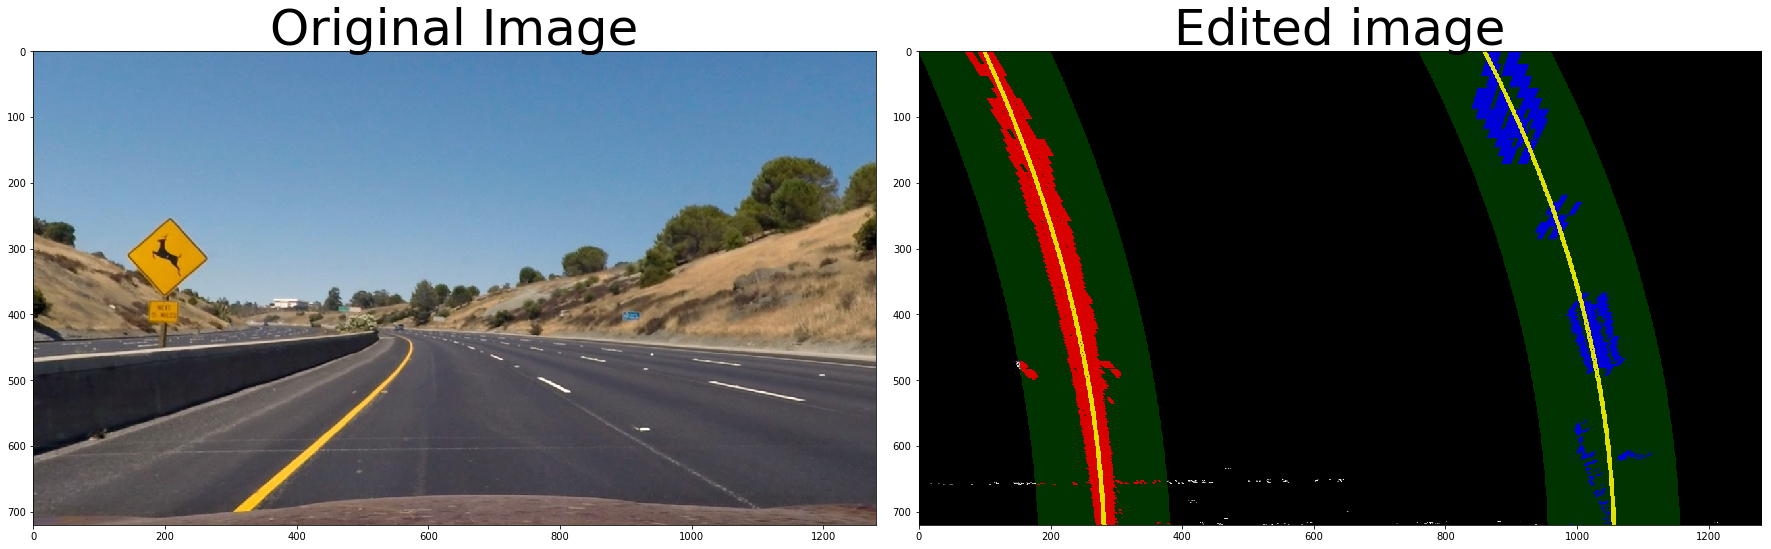

In [129]:
lines_fit, left_line, right_line, res = search_around_poly(combined_warped_image, lines_fit)
plot_images(img, res, None)

In [130]:
def curvature(leftx, rightx, img_shape):
    ym_per_pix = 35/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, img_shape-1, img_shape) #to cover same y-range as image

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix,  2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad


In [131]:
curvature_val = curvature(left_line[0], right_line[0], img.shape[0])
print('The left curvature is ' + str(curvature_val[0]) + ' m')
print('The right curvature is ' + str(curvature_val[1]) +  ' m')

The left curvature is 910.375431844 m
The right curvature is 773.615624176 m


In [132]:
def vehicle_position(img, leftx, rightx):
    xm_per_pix = 3.7/700
    hor_pos = img.shape[1] / 2
    lane_pos = (leftx[-1] + rightx[-1]) / 2
    offset_x = (hor_pos - lane_pos) * xm_per_pix
    return offset_x


In [133]:
offsetx = vehicle_position(img, left_line[0], right_line[0])
print('Offset from x axis is ' + str(offsetx) + 'm')

Offset from x axis is -0.148565147007m


In [134]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


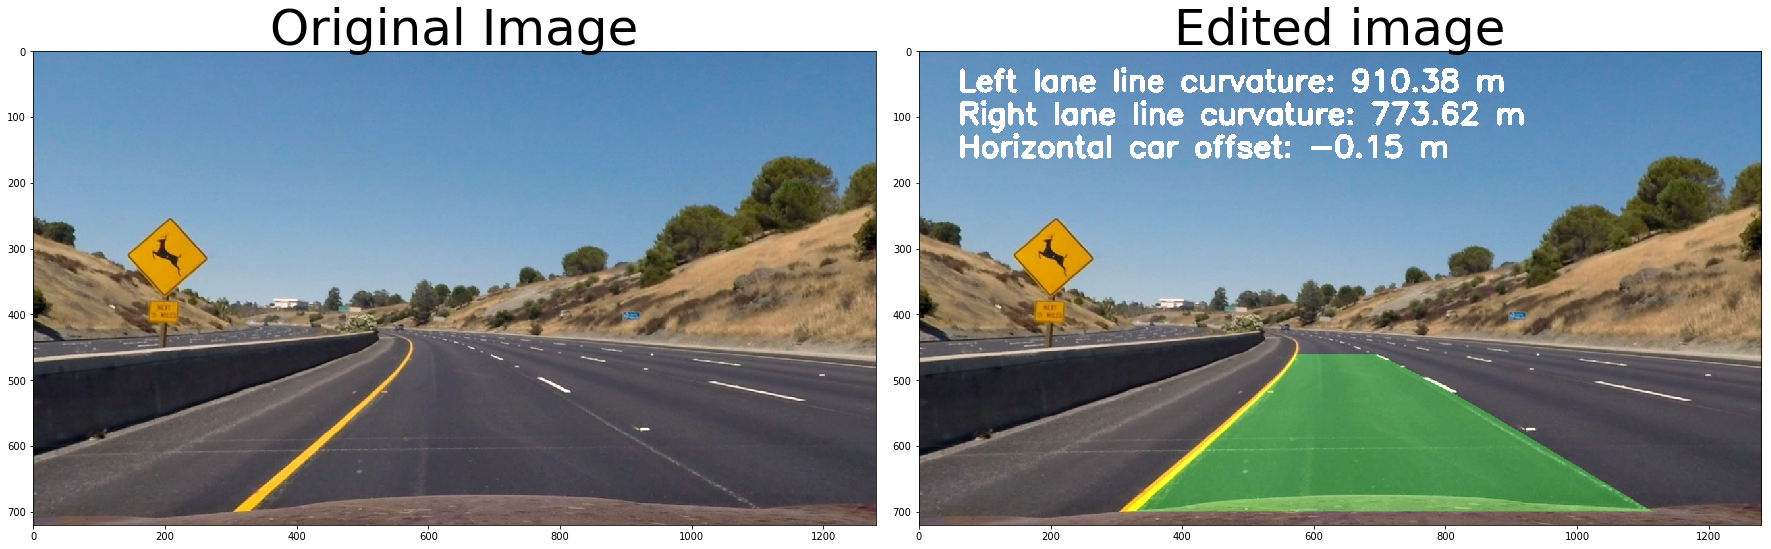

In [135]:
img_lane = draw_lane(img, combined_warped_image, left_line, right_line, M)
cv2.putText(img_lane, 'Left lane line curvature: {:.2f} m'.format(curvature_val[0]), 
                (60, 60), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
cv2.putText(img_lane, 'Right lane line curvature: {:.2f} m'.format(curvature_val[1]), 
            (60, 110), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)

# Display car offset
cv2.putText(img_lane, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
            (60, 160), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)

plot_images(img, img_lane, 'lane')

In [136]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_x = apply_sobel_operator(img, orient='x', sobel_kernel=5, threshold=(30, 100))
        grad_y = apply_sobel_operator(img, orient='y', sobel_kernel=5, threshold=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(30, 100))

        # Calculate gradient direction
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        col_binary = color_threshold(img, thresh=(170, 255))

        # Combine all the thresholds to identify the lane lines
        combined_warped_image = combined_threshold(grad_x, grad_y, mag_binary, dir_binary, col_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        

        combined_warped_image, src, dst, M = perspective_transform(combined_img)
      
        lines_fit, left_line, right_line, out_img = fit_polynomial(combined_warped_image)

        lines_fit, left_line, right_line, res = search_around_poly(combined_warped_image, lines_fit)

        curvature_val = curvature(left_line[0], right_line[0], img.shape[0])
        
        # Calculate car offset
        offsetx = vehicle_position(img, left_line[0], right_line[0])

        img_lane = draw_lane(img, combined_warped_image, left_line, right_line, M)
        
        cv2.putText(img_lane, 'Left lane line curvature: {:.2f} m'.format(curvature_val[0]), 
                (60, 60), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        cv2.putText(img_lane, 'Right lane line curvature: {:.2f} m'.format(curvature_val[1]), 
                    (60, 110), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        cv2.putText(img_lane, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                    (60, 160), cv2.FONT_ITALIC, 1.5, (255,255,255), 5)
        return img_lane

In [137]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video = './project_video.mp4'
output_video = './solution_video.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

./camera_cal/calibration3.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration18.jpg
[MoviePy] >>>> Building video ./solution_video.mp4
[MoviePy] Writing video ./solution_video.mp4


100%|█████████▉| 1260/1261 [08:09<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./solution_video.mp4 

CPU times: user 5min 43s, sys: 20.5 s, total: 6min 4s
Wall time: 8min 12s
